In [100]:
import sys
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('..'))

from src.preprocess import Preprocessor

prep = Preprocessor()

data = pd.read_csv('../data/retail_store_inventory.csv')
clean_data = prep.common_preprocess_data(data.drop(columns=['Demand Forecast'])) # Common preprocessing steps, execept for the 'Demand Forecast' column

clean_data.head()


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,...,Inventory Level_lag_7,Inventory Level_lag_14,Inventory Level_lag_30,Inventory Level_rolling_mean_7,Inventory Level_rolling_mean_14,Inventory Level_rolling_mean_30,price_discount,price_competitiveness,inventory_gap,inventory_turnover
3000,2022-01-31,0,0,0,3,410,200,152,70.78,0,...,115.0,134.0,231.0,311.142857,301.071429,240.500000,0.00,1.027584,258,0.487805
3100,2022-02-01,0,0,3,0,419,279,84,34.49,0,...,348.0,339.0,116.0,321.285714,306.785714,250.600000,0.00,1.018907,335,0.665871
3200,2022-02-02,0,0,1,2,415,38,149,52.49,5,...,200.0,431.0,154.0,352.000000,305.642857,259.300000,262.45,1.087875,266,0.091566
3300,2022-02-03,0,0,0,2,345,71,186,27.71,20,...,410.0,154.0,85.0,342.714286,319.285714,267.966667,554.20,0.956837,159,0.205797
3400,2022-02-04,0,0,2,2,121,25,25,16.84,15,...,158.0,430.0,238.0,337.428571,297.214286,264.066667,252.60,1.343973,96,0.206612


# Time series split

In [101]:
# First we split the data into train and test sets using a time series split by group (Store ID and Product ID).
def temp_split_by_group (df, group_col=['Store ID','Product ID'], test_size=0.2):
    train, test = [], []
    for _, group in df.groupby(group_col):
        group = group.sort_values('Date') # Ensure the group is sorted by date
        n = len(group)
        if n <= 2: # Ensure there are enough samples to split
            continue
        train_size = int(n * (1 - test_size))
        train.append(group.iloc[:train_size])
        test.append(group.iloc[train_size:])
    return pd.concat(train), pd.concat(test)

In [102]:
# Split the data into train and test sets
train, test = temp_split_by_group(clean_data)
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (56000, 38), Test shape: (14100, 38)


In [103]:
# We will now define the target variable and the features to be used for modeling.
target = 'Units Sold' # We define the target variable
exclude_cols = ['Date', target] # We define the columns to exclude from the features, which are the date and target variable columns

features = [col for col in train.columns if col not in exclude_cols] # We create a list of features excluding the target and date columns
X_train, X_test = train[features], test[features] # We create the train and test sets for the features
y_train, y_test = train[target], test[target] # We create the train and test sets for the target variable

# Base line XGBoost model

In [104]:
model = xgb.XGBRegressor() # Initialize the XGBoost model, with default parameters
model.fit(X_train, y_train) # Fit the model to the training data
y_pred = model.predict(X_test) # Predict the target variable for the test set

mse = mean_squared_error(y_test, y_pred) # Calculate the mean squared error of the predictions
print(f"Mean Squared Error: {mse}") # Print the mean squared error
print(f"Mean values: {y_test.mean()}, {y_pred.mean()}") # Print the mean values of the target variable and the predictions

Mean Squared Error: 2.7899279594421387
Mean values: 136.05978723404255, 136.06141662597656


As we can see the mean squared error for the baseline XGBoost model is low, just 2.72 and the difference between the mean of the predicted values and the test values are almost the same

In [105]:
# Now we want to see the MSE by group, to see if there are some groups that are harder to predict than others
test['Units Sold pred'] = y_pred # Add the predictions to the test set
mse_by_group = test.groupby(['Store ID', 'Product ID']).apply(
    lambda x: mean_squared_error(x[target], x['Units Sold pred'])
).reset_index(name='MSE')

# Sort the MSE by group and get the top 10 groups with the highest MSE
top_mse = mse_by_group.sort_values('MSE', ascending=False).head(10)
print(top_mse)

    Store ID  Product ID       MSE
29         1           9  3.787643
67         3           7  3.744664
82         4           2  3.714746
70         3          10  3.682828
77         3          17  3.647042
26         1           6  3.646846
75         3          15  3.612512
85         4           5  3.537659
22         1           2  3.510322
48         2           8  3.429774


C:\Users\DAMER03\AppData\Local\Temp\ipykernel_17472\3582661150.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_group = test.groupby(['Store ID', 'Product ID']).apply(


Text(0.5, 1.0, 'Residuals for Store ID 3, Product ID 6')

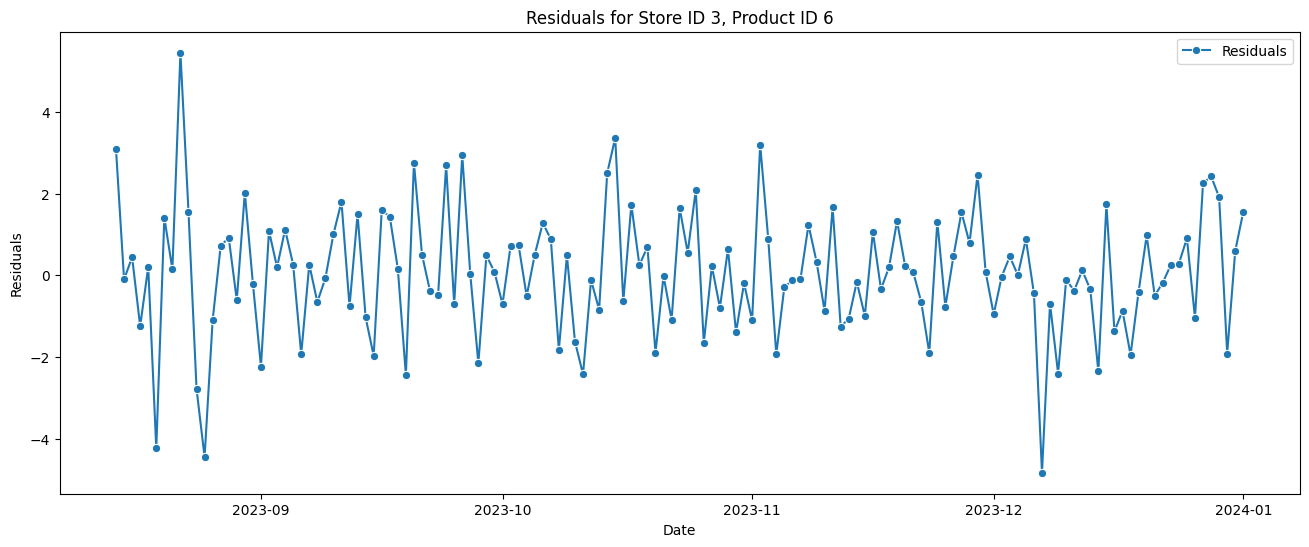

In [106]:
# we can analyze the residuals to see if there are any patterns on the groups with the highest MSE
test['Residuals'] = test[target] - test['Units Sold pred'] # Calculate the residuals

group = test[(test['Store ID'] == 3) & (test['Product ID'] == 6)] # Select a group with high MSE
plt.figure(figsize=(16, 6))
sns.lineplot(data=group, x='Date', y='Residuals', marker='o', label='Residuals')
plt.title(f"Residuals for Store ID {group['Store ID'].iloc[0]}, Product ID {group['Product ID'].iloc[0]}")

There is no visible pattern in the residuals analysis

Text(0.5, 1.0, 'Actual vs Predicted Units Sold for Store ID 1, Product ID 9')

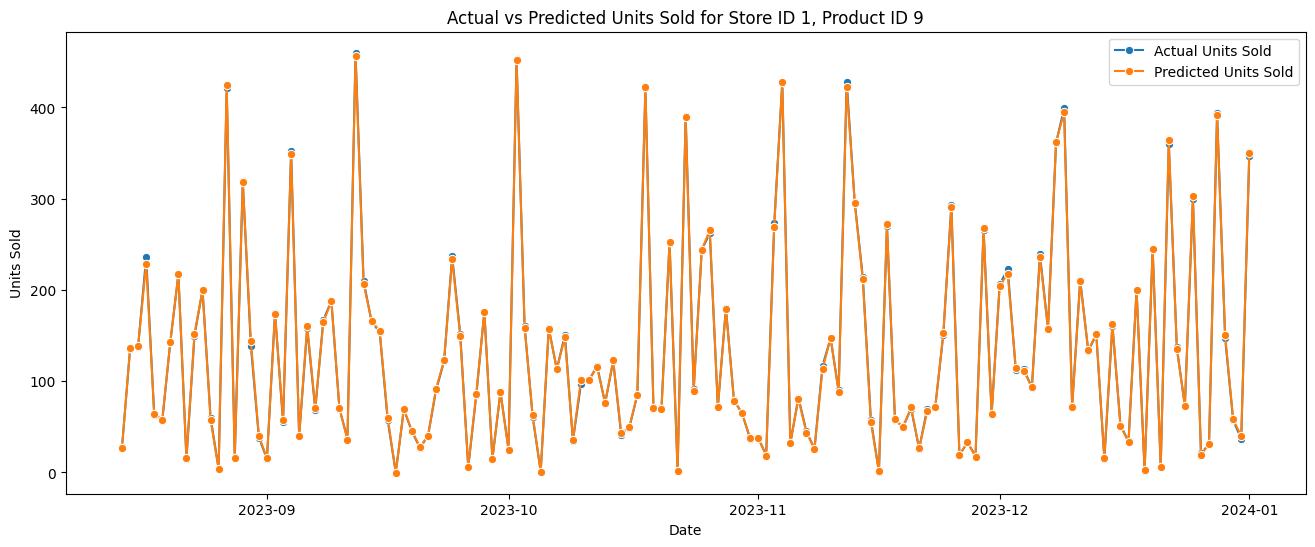

In [107]:
group = test[(test['Store ID'] == 1) & (test['Product ID'] == 9)] # Select a group with high MSE
plt.figure(figsize=(16, 6))
sns.lineplot(data=group, x='Date', y='Units Sold', label='Actual Units Sold', marker='o')
sns.lineplot(data=group, x='Date', y='Units Sold pred', label='Predicted Units Sold', marker='o')
plt.title(f"Actual vs Predicted Units Sold for Store ID {group['Store ID'].iloc[0]}, Product ID {group['Product ID'].iloc[0]}")

We can see that even the base XGBoost model the forecast is really good

# SHAP (Shapley Additive Explanations)